In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import lfilter
import tensorflow as tf
import gym
from gym import wrappers

from keras.models import Model
from keras.layers import Input, Dense, merge
import keras.backend as K

from tqdm import tnrange, tqdm_notebook

Using TensorFlow backend.


In [2]:
def main(env, agent, steps=100000, plot=True):
    try:
        total_rewards = []
        total_reward = 0
        reset = True
        for step in tnrange(steps):
            if reset:
                obs = env.reset()
                agent.reset()
                
                total_rewards.append(total_reward)
                total_reward = 0
            
            action = agent.action(obs)
            new_obs, reward, reset, info = env.step(action)
            agent.observe(obs, action, reward, reset, new_obs)
            
            obs = new_obs
            total_reward += reward
        plt.plot(total_rewards)
    finally:
        env.close()

In [3]:
class RandomAgent(object):
    def __init__(self, env): self.env = env
    def action(self, obs): return self.env.action_space.sample()
    def reset(self): pass
    def observe(self, *args): pass

In [4]:
class ActorCriticAgent(object):
    
    def __init__(self, env, discount=0.95, batchsize=32):
        self.discount = discount
        self.batchsize = batchsize
        model = discrete_model(env)
        self.policy = DiscretePolicy(model)
        model = value_model(env)
        self.value = ValueFunction(model)
        self.rollout = Rollout()
    
    def action(self, obs):
        return self.policy.action(obs)
        
    def observe(self, obs, action, reward, done, new_obs):
        self.rollout.observe(obs, action, reward, done, new_obs)
        if len(self.rollout) >= self.batchsize:
            self.process_rollout()
    
    def reset(self):
        if len(self.rollout):
            self.process_rollout()
        
    def process_rollout(self):
        rollout = self.rollout
        self.rollout = Rollout()
        
        obs = rollout.obs
        action = rollout.action
        reward = rollout.reward
        done = rollout.done[-1]
        terminal_value = self.value(rollout.new_obs[-1]) if not done else 0
        reward.append(terminal_value)
        reward = discount_rewards(reward, self.discount)
        reward = reward[:-1]
        
        obs = np.asarray(obs)
        action = np.asarray(action).reshape((-1, 1))
        reward = np.asarray(reward).reshape((-1, 1))
        
        advantage = reward - self.value.batch(obs)
        self.policy.fit(obs, action, advantage)
        self.value.fit(obs, reward)

In [5]:
def discount_rewards(rewards, discount):
    discounted_rewards = []
    discounted_reward = 0
    for reward in rewards[::-1]:
        discounted_reward = reward + discount * discounted_reward
        discounted_rewards.append(discounted_reward)
    return discounted_rewards[::-1]

In [6]:
class ValueFunction(object):
    
    def __init__(self, model, optimizer='rmsprop'):
        model.compile(loss='mse', optimizer=optimizer)
        self.model = model
        
    def __call__(self, obs):
        obs = np.asarray(obs)
        obs = np.expand_dims(obs, 0)
        value = self.model.predict_on_batch(obs)
        return value[0]
    
    def batch(self, obs):
        obs = np.asarray(obs)
        value = self.model.predict_on_batch(obs)
        return value
    
    def fit(self, obs, reward):
        return self.model.train_on_batch(obs, reward)

In [7]:
def value_model(env):
    obs_shape = env.observation_space.shape
    if len(obs_shape) > 1:
        raise NotImplementedError()
    obs = Input(name='observation', shape=obs_shape)
    hidden = Dense(20, activation='tanh')(obs)
    value = Dense(1)(hidden)
    model = Model(input=obs, output=value)
    return model

In [8]:
class Rollout(object):
    
    def __init__(self):
        self.obs = []
        self.action = []
        self.reward = []
        self.done = []
        self.new_obs = []
    
    def observe(self, obs, action, reward, done, new_obs):
        self.obs.append(obs)
        self.action.append(action)
        self.reward.append(reward)
        self.done.append(done)
        self.new_obs.append(new_obs)
        
    def __len__(self):
        return len(self.obs)

In [9]:
class DiscretePolicy(object):
    
    def __init__(self, model, optimizer='rmsprop'):
        obs = model.input
        proba = model.output
        action = Input(name='action', shape=(1,), dtype='int32')
        action_proba = merge([action, proba], mode=merge_action_proba, output_shape=(1,))
        fit_model = Model(input=[obs, action], output=action_proba)
        fit_model.compile(optimizer=optimizer, loss=policy_loss)
        
        self.fit_model = fit_model
        self.predict_model = model
        
    def action(self, obs):
        obs = np.asarray(obs)
        obs = np.expand_dims(obs, 0)
        proba = self.predict_model.predict_on_batch(obs)[0]
        action = np.random.choice(len(proba), p=proba)
        return action
    
    def fit(self, obs, action, advantage):
        return self.fit_model.train_on_batch([obs, action], advantage)
        
def merge_action_proba(args):
    action, proba = args
    proba_shape = tf.shape(proba)
    batchsize, actions = proba_shape[0], proba_shape[1]
    flat_proba = tf.reshape(proba, [-1])
    flat_action = tf.reshape(action, [-1])
    offset = actions * tf.range(batchsize)
    indices = flat_action + offset
    flat_action_proba = tf.gather(flat_proba, indices)
    action_proba = tf.expand_dims(flat_action_proba, -1)
    return action_proba

def policy_loss(advantage, action_proba):
    advantage = tf.reshape(advantage, [-1])
    action_proba = tf.reshape(action_proba, [-1])
    gain = advantage * tf.log(action_proba)
    loss = -gain
    return loss

In [10]:
def discrete_model(env):
    obs_shape = env.observation_space.shape
    actions = env.action_space.n
    if len(obs_shape) > 1:
        raise NotImplementedError()
        
    obs = Input(name='observation', shape=obs_shape)
    hidden = Dense(40, activation='tanh')(obs)
    hidden = Dense(40, activation='tanh')(hidden)
    proba = Dense(actions, activation='softmax')(hidden)
    model = Model(input=obs, output=proba)
    return model

[2017-01-09 09:35:13,046] Making new env: CartPole-v1
[2017-01-09 09:35:13,075] Attempted to wrap env <CartPoleEnv instance> after .configure() was called. All wrappers must be applied before calling .configure()
[2017-01-09 09:35:13,077] Creating monitor directory tmp
[2017-01-09 09:35:13,348] Starting new video recorder writing to /Users/joshuachin/Documents/actor-critic/tmp/openaigym.video.0.46141.video000000.mp4
/Users/joshuachin/.python3-venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
[2017-01-09 09:35:16,375] Starting new video recorder writing to /Users/joshuachin/Documents/actor-critic/tmp/openaigym.video.0.46141.video000001.mp4
[2017-01-09 09:35:17,193] Starting new video recorder writing to /Users/joshuachin/Documents/actor-critic/tmp/openaigym.video.0.4

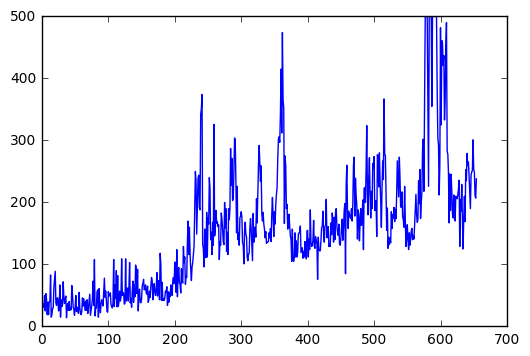

In [11]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, 'tmp', force=True)
agent = ActorCriticAgent(env)
main(env, agent)